In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
root_path = '/content/gdrive/MyDrive/Sino-Nom 2D-3D Retrieval/'

In [ ]:
def extract_filename(filename):
  return int(filename[:-4])

Data loader

In [ ]:
_processed_images = sorted(os.listdir(os.path.join(root_path, 'output', 'processed_images')), key = extract_filename)

_2d_projections = sorted(os.listdir(os.path.join(root_path, 'output', '2d_projections')), key = extract_filename)

In [ ]:
processed_images = []

for file in _processed_images:
  image = cv2.imread(root_path + 'output/processed_images/' + file, cv2.IMREAD_GRAYSCALE)
  processed_images.append(image)

In [ ]:
projections = []

for file in _2d_projections:
  image = cv2.imread(root_path + 'output/2d_projections/' + file, cv2.IMREAD_GRAYSCALE)
  projections.append(image)

Image matching using SIFT algorithm

In [ ]:
sift = cv2.SIFT_create()

In [ ]:
img_kps = []
img_des = []

for img in processed_images:
  img = cv2.GaussianBlur(img, (5, 5), 0)
  kp, des = sift.detectAndCompute(img,None)
  img_kps.append(kp)
  img_des.append(des)

In [ ]:
proj_kps = []
proj_des = []

for img in projections:
  img = cv2.GaussianBlur(img, (5, 5), 0)
  kp, des = sift.detectAndCompute(img,None)
  proj_kps.append(kp)
  proj_des.append(des)

In [ ]:
def image_matching(kp1, des1, kp2, des2):
  # BFMatcher with default params
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(des1,des2, k=2)

  # Apply ratio test
  good = []
  for m,n in matches:
      if m.distance < 0.75*n.distance:
          good.append([m])
  percent = (len(good) * 100.0) / min(len(kp1), len(kp2))
  return percent

Find the top 5 models that have the highest similarities.

In [ ]:
def five_most_similar(kp1, des1, proj_kps, proj_des):
  similarities = []
  indices = []
  for i in range(len(proj_kps)):
    similarity = image_matching(kp1, des1, proj_kps[i], proj_des[i])
    similarities.append(similarity)
    indices.append(i)

  sorted_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)

  top_5_indices = [indices[i] for i in sorted_indices[:5]]

  return [_2d_projections[index][:-3] + 'stl' for index in top_5_indices]

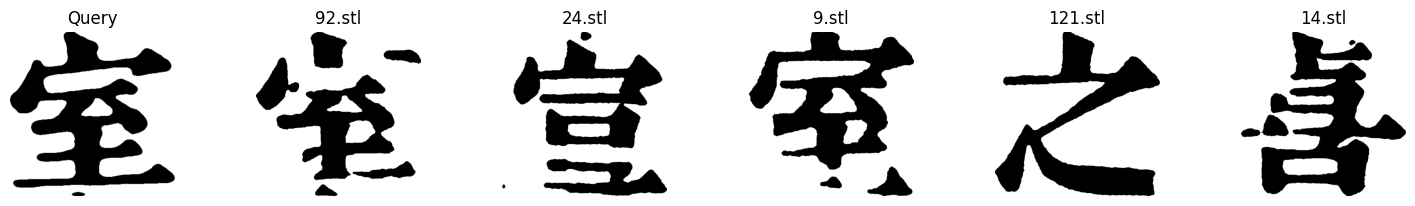

In [37]:
five_images = five_most_similar(img_kps[92], img_des[92], proj_kps, proj_des)


fig, axes = plt.subplots(1, 6, figsize=(18, 6))

axes[0].imshow(processed_images[92], cmap='gray')
axes[0].set_title('Query')
axes[0].axis('off')

for i, ax in enumerate(axes.flat[-5:]):
    ax.imshow(projections[int(five_images[i][:-4])], cmap='gray')
    ax.set_title(five_images[i])
    ax.axis('off')

plt.subplots_adjust(wspace=0.5)

plt.show()

In [ ]:
result = []
for i in range(len(img_kps)):
  top_5_indices = five_most_similar(img_kps[i], img_des[i], proj_kps, proj_des)

  query = [_processed_images[i], top_5_indices]
  result.append(query)
print(result)

[['0.png', ['0.stl', '1.stl', '166.stl', '220.stl', '62.stl']], ['1.png', ['1.stl', '3.stl', '62.stl', '73.stl', '77.stl']], ['2.png', ['2.stl', '206.stl', '71.stl', '61.stl', '110.stl']], ['3.png', ['3.stl', '32.stl', '46.stl', '226.stl', '246.stl']], ['4.png', ['4.stl', '60.stl', '130.stl', '164.stl', '101.stl']], ['5.png', ['5.stl', '77.stl', '136.stl', '66.stl', '170.stl']], ['6.png', ['6.stl', '113.stl', '119.stl', '116.stl', '76.stl']], ['7.png', ['7.stl', '226.stl', '26.stl', '1.stl', '100.stl']], ['8.png', ['8.stl', '209.stl', '156.stl', '137.stl', '47.stl']], ['9.png', ['9.stl', '131.stl', '77.stl', '121.stl', '216.stl']], ['10.png', ['10.stl', '73.stl', '61.stl', '235.stl', '251.stl']], ['11.png', ['11.stl', '89.stl', '249.stl', '173.stl', '176.stl']], ['12.png', ['226.stl', '76.stl', '12.stl', '108.stl', '193.stl']], ['13.png', ['13.stl', '241.stl', '123.stl', '5.stl', '56.stl']], ['14.png', ['113.stl', '56.stl', '108.stl', '224.stl', '14.stl']], ['15.png', ['15.stl', '150.s

Export results as a CSV file.

In [ ]:
for row in result:
    row[1] = ','.join(row[1])
with open(root_path + 'output/sift_result.csv', "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["query", "label"])
    writer.writerows(result)